In [2]:
import inspect
import matplotlib.pyplot as plt
import random
import re
import time
from openai import OpenAI
from sys import maxsize
from tqdm import tqdm
from IPython import get_ipython
import numpy as np
import copy
import time

In [13]:
ipython = get_ipython()
client = OpenAI(api_key = 'sk-proj-zAfbL0i6aR55d0um6PIbT3BlbkFJmv9ZlKICyHqZbZtuvYJo')
pattern = re.compile(r'```python\n(.*?)```', re.DOTALL)

In [63]:
completion = client.chat.completions.create(
    model='gpt-4-turbo',
    messages=[
    {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems.'},
    {'role': 'user', 'content': 'What is a heuristic algorithm for solving the bin packing problem? The input is an array of integer item weights, representing the size of each item, and a single integer bin size representing the constant size of all bins. The output should be an array of bin indices representing which bin each item should go into. No bin should have item weights exceeding its capacity. Make sure the code is correct and has polynomial time complexity in the number of nodes. Output only the code with the function and nothing else.'}
  ]
)

In [64]:
res = completion.choices[0].message.content
code = pattern.findall(res)[0]
print(code)

def first_fit(items, bin_capacity):
    # Array to store the result bin for each item.
    bins = []
    # List to keep track of the current capacity of each bin.
    bin_capacities = []

    for item in items:
        placed = False
        # Try to place the item in the existing bins.
        for i in range(len(bin_capacities)):
            if bin_capacities[i] + item <= bin_capacity:
                bin_capacities[i] += item
                bins.append(i)
                placed = True
                break
        # If it does not fit in any existing bin, create a new bin.
        if not placed:
            bins.append(len(bin_capacities))
            bin_capacities.append(item)

    return bins



In [10]:
def generate_items(num_items):
    items = []
    for _ in range(num_items):
        items.append(random.randint(10, 25))
    bin_weight = random.randint(25, 35)
    return items, bin_weight

def count_bins(items, bins, bin_weight):
    bin_weights = {}

    for i in range(len(items)):
        if bins[i] in bin_weights:
            bin_weights[bins[i]] += items[i]
        else:
            bin_weights[bins[i]] = items[i]

    for val in bin_weights.values():
        assert(val <= bin_weight)

    return len(set(bins))

def first_fit(items, bin_weight):
    item_assignments = [0] * len(items)
    bins = [bin_weight] * len(items)
    for i in range(len(items)):
        for j in range(len(bins)):
            if bins[j] >= items[i]:
                bins[j] -= items[i]
                item_assignments[i] = j
                break
    return item_assignments

def best_fit(items, bin_weight):
    item_assignments = [0] * len(items)
    bins = [bin_weight] * len(items)
    for i in range(len(items)):
        tightest = bin_weight
        bin = 0
        for j in range(len(bins)):
            if bins[j] >= items[i] and bins[j] - items[i] < tightest:
                tightest = bins[j] - items[i]
                bin = j
        item_assignments[i] = bin
        bins[bin] -= items[i]
    return item_assignments

In [95]:
evaluation = ''.join(inspect.getsourcelines(count_bins)[0])

items, bin_weight = generate_items(10)
completion = client.chat.completions.create(
    model='gpt-4-turbo',
    messages=[
    {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems.'},
    {'role': 'user', 'content': f'What is a heuristic algorithm for solving the bin packing problem? The input is an array of integer item weights, representing the size of each item, such as {items} and a single integer bin size representing the constant size of all bins such as {bin_weight}. The output should be an array of bin indices representing which bin each item should go into indexed the same as the original items array. No bin should have item weights exceeding its capacity. Make sure the code is correct and has polynomial time complexity in the number of nodes and runs successfully on an input, such as {items} and {bin_weight}. The code is scored using {evaluation}, with a lower bin count being better. Output only the code with the function and nothing else. Make sure the code is correct.'}
  ]
)
res = completion.choices[0].message.content
code = pattern.findall(res)[0]
feedback = [None, None, None]

for _ in tqdm(range(8)):
    code = res
    reflection = client.chat.completions.create(
        model='gpt-4-turbo',
        messages=[
        {'role': 'system', 'content': 'You are a thoughtful agent who reflects on the given heuristic algorithm for solving NP-complete problems and give feedback on how to improve the heuristic algorithm while maintaining or improving time complexity.'},
        {'role': 'user', 'content': f'Here is a heuristic algorithm for solving the bin packing problem : {code}. Provide a single suggestion on how to improve the heuristic algorithm while maintaining or improving time complexity in words only, no code. Consider heuristic algorithms such as greedy methods, local search, branch and bound, and/or exploiting symmetry. Try to surpass performance of decreasing first fit.'}
    ]
    )
    feedback.append(reflection.choices[0].message.content)
    feedback = feedback[1:]
    completion = client.chat.completions.create(
        model='gpt-4-turbo',
        messages=[
        {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems and takes feedback to improve upon yourself.'},
        {'role': 'user', 'content': f'What is a heuristic algorithm for solving the bin packing problem? The input is an array of integer item weights, representing the size of each item, such as {items} and a single integer bin size representing the constant size of all bins such as {bin_weight}. The output should be an array of bin indices representing which bin each item should go into indexed the same as the original items array. No bin should have item weights exceeding its capacity. Make sure the code is correct and has polynomial time complexity in the number of nodes and runs successfully on an input, such as {items} and {bin_weight}. The code is scored using {evaluation}, with a lower bin count being better. Output only the code with the function and nothing else. Here is some feedback from the previous iterations: {feedback[0]}, {feedback[1]}, {feedback[2]}. Here is the current code: {code}. Provide a modification to this code to achieve a lower bin count. Make sure the code is correct.'}
    ]
    )
    res = completion.choices[0].message.content
    code = pattern.findall(res)[0]

print(code)

100%|██████████| 8/8 [04:52<00:00, 36.51s/it]

def bin_packing(items, bin_capacity):
    # Sort items in decreasing order
    items_sorted = sorted(items, reverse=True)
    bins = []
    bin_capacities = []

    # Iterate over each sorted item and try to place it via Best Fit Decreasing strategy
    for item in items_sorted:
        best_fit_index = -1
        min_space_left = float('inf')

        # Find the bin that will have the least remaining space after placing this item, but can still fit the item
        for i in range(len(bin_capacities)):
            if bin_capacities[i] + item <= bin_capacity:
                space_left = bin_capacity - (bin_capacities[i] + item)
                if space_left < min_space_left:
                    min_space_left = space_open
                    best_fit_index = i

        # If no bin was found that could fit the item, create a new bin
        if best_fit_index == -1:
            bins.append([item])
            bin_capacities.append(item)
        else:
            # Place the item in the b

In [4]:
def bp_heuristic(items, bin_capacity):
    # Array to store the result bin for each item.
    bins = []
    # List to keep track of the current capacity of each bin.
    bin_capacities = []

    for item in items:
        placed = False
        # Try to place the item in the existing bins.
        for i in range(len(bin_capacities)):
            if bin_capacities[i] + item <= bin_capacity:
                bin_capacities[i] += item
                bins.append(i)
                placed = True
                break
        # If it does not fit in any existing bin, create a new bin.
        if not placed:
            bins.append(len(bin_capacities))
            bin_capacities.append(item)
            

    return bins


In [6]:
# 1 feedback result
def bp_heuristic_1(items, bin_capacity):
    bins = []
    bin_weights = []

    for item in items:
        placed = False

        # Try to place the item in the best suitable bin (First Fit Decreasing)
        for i in range(len(bin_weights)):
            if bin_weights[i] + item <= bin_capacity:
                bins.append(i)  # Assign this item to bin i
                bin_weights[i] += item
                placed = True
                break
        
        # If no suitable bin exists, create a new one
        if not placed:
            bins.append(len(bin_weights))  # Assign to a new bin
            bin_weights.append(item)

    return bins

In [7]:
def bp_heuristic_5(items, bin_capacity):
    # Sort items in descending order
    sorted_items = sorted(items, reverse=True)
    bins = []
    bin_weights = []
    bin_indexes = [-1] * len(items)  # Initialize bin_indexes with -1 for all items

    for item_index, item in enumerate(sorted_items):
        # Best fit strategy: find the tightest bin that can accommodate the item
        best_bin = None
        min_space_left = float('inf')

        for i, b_weight in enumerate(bin_weights):
            if b_weight + item <= bin_capacity and (bin_capacity - (b_weight + item)) < min_space_left:
                best_bin = i
                min_space_left = bin_capacity - (b_weight + item)

        if best_bin is not None:
            bin_weights[best_bin] += item
            original_index = items.index(item)
            items[original_index] = -1  # Mark the item as placed by setting it to -1
            bin_indexes[original_index] = best_bin
        else:
            bins.append([item])
            bin_weights.append(item)
            original_index = items.index(item)
            items[original_index] = -1  # Mark the item as placed by setting it to -1
            bin_indexes[original_index] = len(bins) - 1  # Correct index adjustment for new bin

    # Restore the original items array for accurate indexing in multiple function calls
    for i, item in enumerate(sorted_items):
        items[items.index(-1)] = item

    return bin_indexes


In [15]:
k = 50
x = list(range(5, 61, 5))

y0, y1, y2, y3, y4 = [], [], [], [], []

for i in x:
    print(f'Running on {i} items')
    cost0, cost1, cost2, cost3, cost4 = 0, 0, 0, 0, 0
    for _ in range(k):
        items, bin_weight = generate_items(i)
        bins_best_fit = best_fit(items, bin_weight)
        bins_first_fit = first_fit(items, bin_weight)
        bins2 = bp_heuristic(copy.deepcopy(items), bin_weight)
        bins3 = bp_heuristic_1(copy.deepcopy(items), bin_weight)
        bins4 = bp_heuristic_5(copy.deepcopy(items), bin_weight)

        cost0 += count_bins(items, bins_best_fit, bin_weight)
        cost1 += count_bins(items, bins_first_fit, bin_weight)
        cost2 += count_bins(items, bins2, bin_weight)
        cost3 += count_bins(items, bins3, bin_weight)
        cost4 += count_bins(items, bins4, bin_weight)

    y0.append(cost0 / k)
    y1.append(cost1 / k)
    y2.append(cost2 / k)
    y3.append(cost3 / k)
    y4.append(cost4 / k)

Running on 5 items
Running on 10 items
Running on 15 items
Running on 20 items
Running on 25 items
Running on 30 items
Running on 35 items
Running on 40 items
Running on 45 items
Running on 50 items
Running on 55 items
Running on 60 items


In [9]:
print(y0)
print(y1)
print(y2)
print(y3)
print(y4)

[3.9, 7.7, 10.6, 15.02, 18.72, 21.2, 24.92, 29.28, 32.5, 36.26, 40.62, 42.7]
[3.9, 7.76, 10.62, 15.08, 18.84, 21.34, 25.1, 29.46, 32.72, 36.44, 40.86, 43.02]
[3.9, 7.76, 10.62, 15.08, 18.84, 21.34, 25.1, 29.46, 32.72, 36.44, 40.86, 43.02]
[3.9, 7.76, 10.62, 15.08, 18.84, 21.34, 25.1, 29.46, 32.72, 36.44, 40.86, 43.02]
[3.88, 7.56, 10.24, 14.5, 18.24, 20.3, 24.08, 28.56, 31.56, 35.32, 39.46, 41.6]


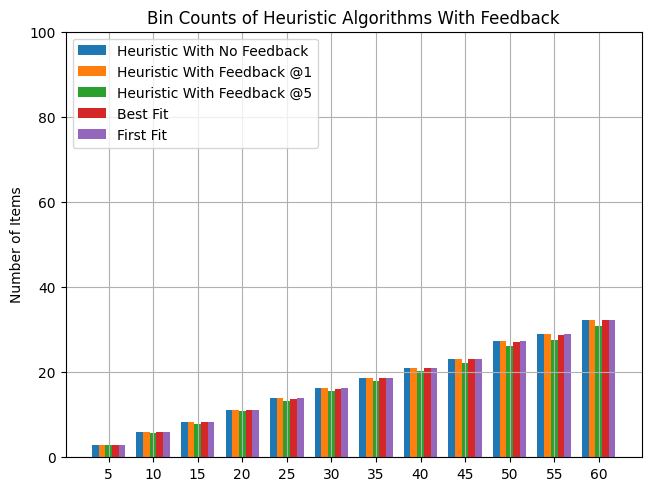

In [16]:
width = 0.75  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for y, label in zip([y2, y3, y4, y0, y1], ['Heuristic With No Feedback', 'Heuristic With Feedback @1', 'Heuristic With Feedback @5', 'Best Fit', 'First Fit']):
    offset = width * multiplier
    rects = ax.bar(np.array(x) + offset, y, width, label=label)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Bins')
ax.set_ylabel('Number of Items')
ax.set_title('Bin Counts of Heuristic Algorithms With Feedback')
ax.set_xticks(np.array(x) + 2 * width, x)
ax.legend(loc='upper left')
ax.set_ylim(0, 100)
ax.grid()

plt.show()

In [17]:
k = 50
x = list(range(5, 61, 5))

y0, y1, y2, y3, y4 = [], [], [], [], []

for i in x:
    print(f'Running on {i} items')
    t0, t1, t2, t3, t4 = 0, 0, 0, 0, 0
    for _ in range(k):
        items, bin_weight = generate_items(i)

        start_time = time.time()
        bins1 = best_fit(copy.deepcopy(items), bin_weight)
        end_time = time.time()
        t0 += end_time - start_time

        start_time = time.time()
        bins1 = first_fit(copy.deepcopy(items), bin_weight)
        end_time = time.time()
        t1 += end_time - start_time

        start_time = time.time()
        bins2 = bp_heuristic(copy.deepcopy(items), bin_weight)
        end_time = time.time()
        t2 += end_time - start_time

        start_time = time.time()
        bins3 = bp_heuristic_1(copy.deepcopy(items), bin_weight)
        end_time = time.time()
        t3 += end_time - start_time

        start_time = time.time()
        bins4 = bp_heuristic_5(copy.deepcopy(items), bin_weight)
        end_time = time.time()
        t4 += end_time - start_time

    y0.append(t0 / k)
    y1.append(t1 / k)
    y2.append(t2 / k)
    y3.append(t3 / k)
    y4.append(t4 / k)

Running on 5 items
Running on 10 items
Running on 15 items
Running on 20 items
Running on 25 items
Running on 30 items
Running on 35 items
Running on 40 items
Running on 45 items
Running on 50 items
Running on 55 items
Running on 60 items


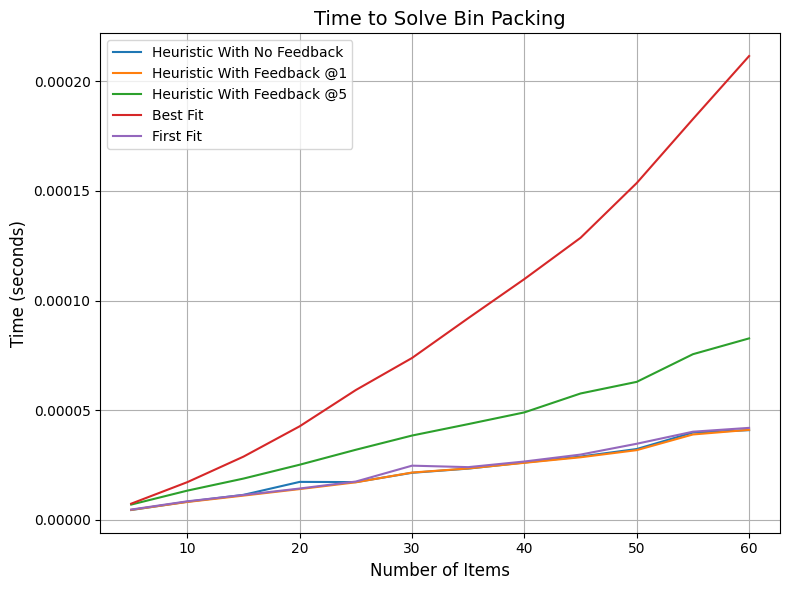

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(x, y2, label='Heuristic With No Feedback')
plt.plot(x, y3, label='Heuristic With Feedback @1')
plt.plot(x, y4, label='Heuristic With Feedback @5')
plt.plot(x, y0, label='Best Fit')
plt.plot(x, y1, label='First Fit')


plt.legend()
plt.xlabel('Number of Items', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time to Solve Bin Packing', fontsize=14)
plt.grid(True)
plt.tight_layout()